# Robust training of polynomials demo
In this notebook, we walk the reader through the different steps of the framework and train robust hypotheses using polynomials. In the first section, we will train a holomorphic 1D complex classifiers and recreate Figure 1. In the second section, we will train 2D real analytic classifiers under the same framework.

## Holomorphic optimal Bayes classifier
The holomorphic optimal Bayes classifier is the orthogonal projection of the optimal Bayes classifier in $\mathcal{O}(\mathcal{X})$. To compute the projection, we need the Bergman kernel of $\mathcal{X}$. In case $\mathcal{X}$ is the boundary of some domain, we can use the Szeg\H{o} kernel instead. Keep in mind that Szeg\H{o} projection is not equal with the Bergman projection of a constant extension of the optimal Bayes classifier on the boundry into the domain.

The Szeg\H{o} kernel of the unit disk is
$$
S(z,\zeta) = \frac{1}{2\pi}\frac{1}{1 - z\overline{\zeta}}.
$$
And the the function that we want to project into $\mathcal{O}(\mathcal{X})$ is $f_\mathcal{D}(z)=\mathrm{sign}(\Re[z])$. Thus, we want to compute
$$
f(z) = \frac{1}{2\pi}\int_{\partial{\mathcal{X}}}\frac{\mathrm{sign}(\Re[\zeta])}{1-z\overline{\zeta}}\,d\zeta=\frac{1}{2\pi}\big(\int_{-\frac{\pi}{2}}^{\frac{\pi}{2}}\frac{1}{1 - ze^{-i\theta}}\,d\theta - \int_{\frac{\pi}{2}}^{\frac{3\pi}{2}}\frac{1}{1 - ze^{-i\theta}}\,d\theta\big).
$$

In [4]:
import sympy as sp
theta, z = sp.Symbol('t', real=True), sp.Symbol('z', real=False)
o = sp.simplify((sp.integrate(1 / (1 - z*sp.exp(-1j * theta)), (theta, -sp.pi/2, sp.pi/2)) - sp.integrate(1 / (1 - z*sp.exp(-1j * theta)), (theta, sp.pi/2, 3*sp.pi/2))) / (2*sp.pi))
o

I*(log(-z - I) - 1.0*log(-z + I))/pi

The projection has two logaramitic branch points. We are free to choose the direction of the branch cuts, we rotate them by 90 degree in opposite directions so that the branch cuts fall on the decision boundary and outside of the domain $\mathcal{X}$. To rotate the branch cuts by an angle $\phi$, we have to multiply the expression inside the logarithms by $e^{i\phi}$. Thus, the projection of $f_\mathcal{D}(z)$ into $\mathcal{O}(\mathcal{X})$ is
$$
o_\mathcal{D}(z)=\frac{i}{\pi}\big( \ln(i(-z-i)) - \ln(-i(-z+i)) \big)
$$

## Orthonormal complex polynomials
As we have described in the paper, the orthonomal basis polynomials for $A^2(\mathbb{D})$ is
$$
\varphi_k(z)=\sqrt{\frac{k+1}{\pi}}z^k.
$$

We first generate the training samples

In [5]:
import numpy as np

n = 30
d = 30

xx = np.linspace(-1, 1, n+1)[:-1]
X_train = np.exp(1j * np.pi * xx)
y_train = np.sign(np.real(X_train))

Next, we implement the complex-valued SVC learning rule with the aid of a [convex optimization library](https://www.cvxpy.org/).

In [6]:
import cvxpy as cp

In, Id = np.eye(n), np.eye(d)

wr = cp.Variable(d)
wi = cp.Variable(d)
ksi = cp.Variable(n)

Vr = cp.Parameter((n, d))
Vi = cp.Parameter((n, d))

constraints = [
  ksi >= 0,
  cp.multiply(y_train, Vr @ wr - Vi @ wi) >= 1 - ksi,
  Vr @ wi + Vi @ wr <= ksi,
  -ksi <= Vr @ wi + Vi @ wr
]

obj = cp.Minimize(cp.sum(ksi) + cp.quad_form(wr, Id) + cp.quad_form(wi, Id))

problem = cp.Problem(obj, constraints)

Finally, we substitue the data into the problem and run the solver.

In [7]:
gamma = lambda _n: np.pi / (_n+1)

def vander(Z):
  return np.array([Z ** i / np.sqrt(gamma(i)) for i in range(d)]).T

V = vander(X_train)

Vr.value = np.real(V) 
Vi.value = np.imag(V)

problem.solve()

w_orth = wr.value + 1j * wi.value

## Harmonic complex polynomials

We first have to compute the tuning matrix $\Sigma$ for the orthonormal basis $\varphi$
$$
\Sigma_{jk}=\int_\mathbb{D} \varphi_j(z)'\varphi_k(z)'\,dxdy.
$$

In [8]:
from scipy.linalg import sqrtm

Sigma = np.diag([i ** 2 * gamma(i-1) / gamma(i) for i in range(1, d)])

Then, we compute the harmonic features
$$
\varphi^*=\Sigma^\frac{-1}{2}\varphi,
$$
and finally, we will replace the new data in our learning rule and compute the robust classifier.

In [9]:
S = np.eye(d)
S[1:, 1:] = sqrtm(np.linalg.inv(Sigma))

V = V @ S

Vr.value = np.real(V) 
Vi.value = np.imag(V)

problem.solve()

w_harm = wr.value + 1j * wi.value

Now, we can graph the optimal Bayes, the orthonormal and the harmonic holomorphic hypothesis for our problem.

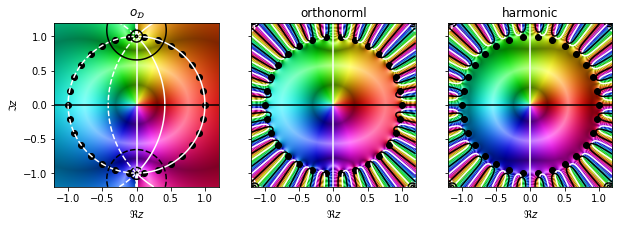

In [10]:
import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
from dcolor import DColor

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 10))

def clp_bayes(Z):
    return 1j * (np.log(1j*(-Z-1j))-np.log(-1j*(-Z+1j))) / np.pi

def clp_orth(Z):
    z = Z.flatten()
    phi = vander(z)
    out = phi @ w_orth

    return out.reshape(Z.shape)

def clp_harm(Z):
    z = Z.flatten()
    phi = vander(z) @ S
    out = phi @ w_harm

    return out.reshape(Z.shape)

dc = DColor(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, samples=200)
dc.plot(clp_bayes, ax=ax[0])
ax[0].scatter(np.real(X_train), np.imag(X_train), c='black')
ax[0].set_title('$o_\mathcal{D}$')
ax[0].set_xlabel('$\Re z$')
ax[0].set_ylabel('$\Im z$')

dc.plot(clp_orth, ax=ax[1])
ax[1].scatter(np.real(X_train), np.imag(X_train), c='black')
ax[1].set_title('orthonorml')
ax[1].set_xlabel('$\Re z$')

dc.plot(clp_harm, ax=ax[2])
ax[2].scatter(np.real(X_train), np.imag(X_train), c='black')
ax[2].set_title('harmonic')
ax[2].set_xlabel('$\Re z$')

fig.savefig('disk.eps', bbox_inches='tight', dpi=150)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


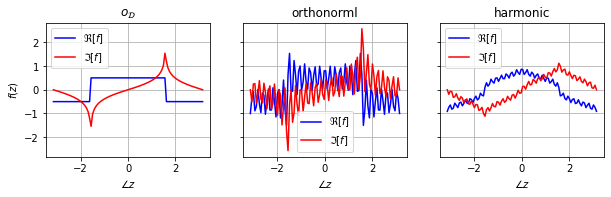

In [11]:
xx_test = np.linspace(-np.pi, np.pi, 100)
Z_test = np.exp(1j * xx_test)

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 10))
ax[0].set_aspect('equal')
ax[0].grid()
ax[0].plot(xx_test, np.real(clp_bayes(Z_test)), c='b', label='$\Re[f]$')
ax[0].plot(xx_test, np.imag(clp_bayes(Z_test)), c='r', label='$\Im[f]$')
ax[0].set_title('$o_\mathcal{D}$')
ax[0].set_ylabel('$f(z)$')
ax[0].set_xlabel('$\\angle z$')
ax[0].legend()

ax[1].set_aspect('equal')
ax[1].grid()
ax[1].plot(xx_test, np.real(clp_orth(Z_test)), c='b', label='$\Re[f]$')
ax[1].plot(xx_test, np.imag(clp_orth(Z_test)), c='r', label='$\Im[f]$')
ax[1].set_title('orthonorml')
ax[1].set_xlabel('$\\angle z$')
ax[1].legend()

ax[2].set_aspect('equal')
ax[2].grid()
ax[2].plot(xx_test, np.real(clp_harm(Z_test)), c='b', label='$\Re[f]$')
ax[2].plot(xx_test, np.imag(clp_harm(Z_test)), c='r', label='$\Im[f]$')
ax[2].set_title('harmonic')
ax[2].set_xlabel('$\\angle z$')
ax[2].legend()

fig.savefig('circle.eps', bbox_inches='tight', dpi=150)

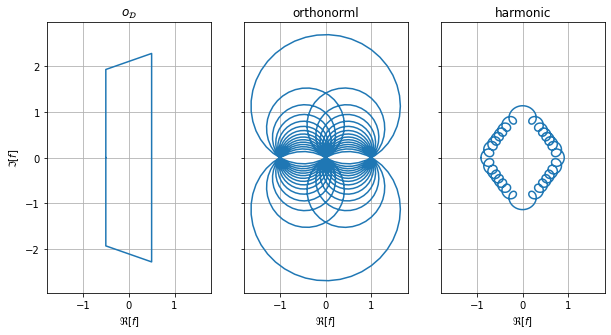

In [12]:
xx_test = np.linspace(-np.pi, np.pi, 1000)
Z_test = np.exp(1j * xx_test)

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 10))
ax[0].set_aspect('equal')
ax[0].grid()
ax[0].plot(np.real(clp_bayes(Z_test)), np.imag(clp_bayes(Z_test)))
ax[0].set_title('$o_\mathcal{D}$')
ax[0].set_ylabel('$\Im[f]$')
ax[0].set_xlabel('$\Re[f]$')

ax[1].set_aspect('equal')
ax[1].grid()
ax[1].plot(np.real(clp_orth(Z_test)), np.imag(clp_orth(Z_test)))
ax[1].set_title('orthonorml')
ax[1].set_xlabel('$\Re[f]$')

ax[2].set_aspect('equal')
ax[2].grid()
ax[2].plot(np.real(clp_harm(Z_test)), np.imag(clp_harm(Z_test)))
ax[2].set_title('harmonic')
ax[2].set_xlabel('$\Re[f]$')

fig.savefig('image.eps', bbox_inches='tight', dpi=150)

## Orthonormal and harmonic 2D Chebyshev polynomials

To showcase the framework in a real-valued hypothesis, we will train a robust polynomial classifier for $x\in[-1,1]^2$. We will use the 2D Chebyshev polynomials $T_{ij}$ as features, and the labeling function would be
$$
f_\mathcal{D}(x) = \mathrm{sign}\big(\max(|x|) - 0.5\big)
$$

Similar to complex polynomials, we have to first generate the training points and the tuning matrix. Since we are assuming that the domain is real, we cannot calculate the holomorphic optimal Bayes classifier, because we don't know the convergence region of the hypothesis before hand. 

In [13]:
from itertools import product
from numpy.polynomial import chebyshev as ch

n = 10

def It(i, j):
    """
    A helper function that computes the inner product between Chebyshev basis of the first kind
    """
    if not i == j:
        return 0
    if i == 0:
        return np.pi
    return np.pi / 2

def Iu(i, j):
    """
    A helper function that computes the inner product between Chebyshev basis of the second kind
    """
    if i % 2 == 0 and j % 2 == 0:
        return np.pi + 2 * np.pi * np.floor(min(i, j) / 2)
    if i % 2 == 1 and j % 2 == 1:
        return 2 * np.pi * np.ceil(min(i, j) / 2)
    return 0

Sigma = np.zeros(((d+1)**2, (d+1)**2))
for j, k in product(range(d+1), range(d+1)):
  for l, m in product(range(d+1), range(d+1)):
    Sigma[(d+1) * j + k, (d+1) * l + m] = j * l * Iu(j-1, l-1) * It(k, m) + k * m * It(j, l) * Iu(k-1, m-1)

Sigma = Sigma[1:,1:]

Xs, Ys = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, n))
Xt, Yt = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(-1, 1, 200))

y = np.sign(np.max(np.abs(np.vstack([Xs.flatten(), Ys.flatten()])), axis=0) - 0.5)

X_train_orth = ch.chebvander2d(Xs.flatten(), Ys.flatten(), [d, d])[:, 1:]
X_test_orth = ch.chebvander2d(Xt.flatten(), Yt.flatten(), [d, d])[:, 1:]

X_train_harm = X_train_orth @ np.real(sqrtm(np.linalg.inv(Sigma)).T)
X_test_harm = X_test_orth @ np.real(sqrtm(np.linalg.inv(Sigma)).T)

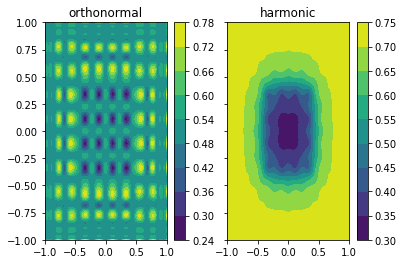

In [14]:
from sklearn.svm import LinearSVC

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

cls = LinearSVC()
cls.fit(X_train_orth, y)

w_orth = np.hstack([cls.coef_[0]])
b_orth = cls.intercept_[0]

yhat = cls._predict_proba_lr(X_test_orth)[:, 1]

pc0 = ax[0].contourf(Xt, Yt, yhat.reshape(Xt.shape))
ax[0].set_title('orthonormal')

cls.fit(X_train_harm, y)

w_sync = sqrtm(Sigma) @ cls.coef_[0]
b_sync = cls.intercept_[0]

yhat = cls._predict_proba_lr(X_test_harm)[:, 1]

pc1 = ax[1].contourf(Xt, Yt, yhat.reshape(Xt.shape))
ax[1].set_title('harmonic')


plt.colorbar(pc0, ax=ax[0])
plt.colorbar(pc1, ax=ax[1])

Since the features are real analytic, they have a natural extension to complex numbers. In the next graph, we will slice $\mathbb{C}^2$ through the axis of the first dimenstion (in the direction of the vector $[1,0]^T$), and plot the hypothesis on this slice.

C:\Users\Ramin\AppData\Roaming\Python\Python38\site-packages\numpy\polynomial\polyutils.py:479: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  points = tuple(np.array(tuple(points), copy=False) + 0.0)


Text(0.5, 1.0, 'harmonic')

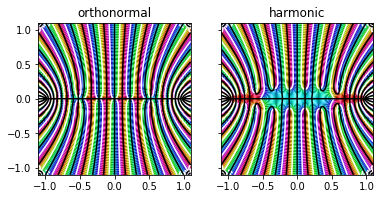

In [15]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

def clp_orth(Z, direction):
    z = Z.flatten()
    phi = ch.chebvander2d(z, 0, [d, d])[:, 1:]
    out = phi @ w_orth + b_orth

    return out.reshape(Z.shape)

def clp_sync(Z, direction):
    z = Z.flatten()
    phi = ch.chebvander2d(z, 0, [d, d])[:, 1:] @ sqrtm(np.linalg.inv(Sigma)).T
    out = phi @ w_sync + b_sync

    return out.reshape(Z.shape)

dir = [1, 0]
dc = DColor(xmin=-1.1, xmax=1.1, ymin=-1.1, ymax=1.1, samples=200)
dc.plot(lambda z: clp_orth(z, dir), ax=ax[0])
ax[0].set_title('orthonormal')
dc.plot(lambda z: clp_sync(z, dir), ax=ax[1])
ax[1].set_title('harmonic')

Same as before, we conclude that the robust SVC learning rule successfully learns the robust decision boundary. As expected, the region of the convergence of the harmonic classifier in $\mathbb{C}^2$ is larger than the region of convergence of the orthonormal classifier; even when no complex data is involved.